<a href="https://colab.research.google.com/github/Alina9/DUL/blob/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 32.93 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16678 sha256=41680e1a08ebc9ecb396464486a4f0deaa6e14c77f4b5f58770a11305ae5515f
  Stored in directory: /tmp/pip-ephem-wheel-cache-24dgrdq3/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [ ]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


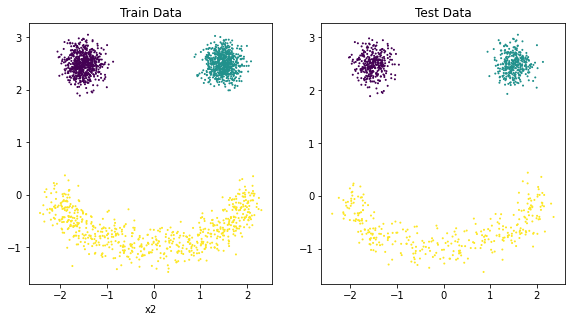

Dataset 2


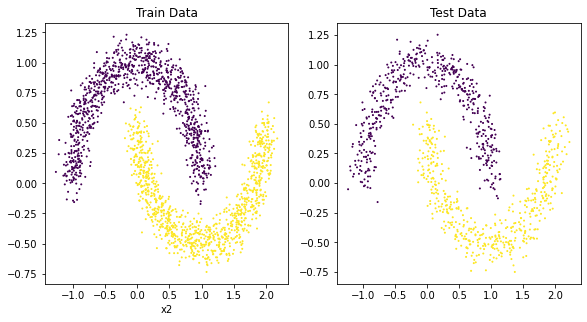

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, train_loader, test_loader,  optimizer, epoch):
  train_losses = []
  test_losses = []
  for e in range(epoch):
    model.train()    
    epoch_losses = []
    for x in train_loader:
      x = x.to(device).float().contiguous()
      loss = model.loss(x)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_losses.append(loss.item())
    train_losses.extend(epoch_losses)

    # test
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if e%10 == 0:
      print(f'Epoch {e}, Test loss {test_loss}')
  return train_losses, test_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.to(device).float().contiguous()
      loss = model.loss(x)
      total_loss += loss.item() * x.shape[0]
  return total_loss / len(data_loader.dataset)

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

In [ ]:
class MixCDF(nn.Module):
  def __init__(self, k = 4):
    super(MixCDF, self).__init__()
    self.base_dist = Uniform(0.0, 1.0)
    self.k = k
    self.logits = nn.Parameter(torch.zeros(k), requires_grad=True)
    self.means = nn.Parameter(torch.zeros(k), requires_grad=True)
    self.log_s = nn.Parameter(torch.randn(k), requires_grad=True)
  
  def forward(self, x):
    x = x.unsqueeze(1).repeat(1, self.k)
    weights = F.softmax(self.logits, dim=0).unsqueeze(0).repeat(x.shape[0], 1)
    std = self.log_s.exp()
    norm = Normal(self.means, std)
    z = (norm.cdf(x)*weights).sum(1)
    log_det = (torch.exp(norm.log_prob(x))*weights).sum(1).log()
    return z, log_det


In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size,output_size)
    self.relu = nn.ReLU()
    self.k = output_size//3
  
  def forward(self, x):
    output = self.relu(self.linear1(x))
    output = self.relu(self.linear2(output))
    output = self.relu(self.linear3(output))
    output = self.linear4(output)
    return output


In [ ]:
class conditionalMixCDF(nn.Module):
  def __init__(self, input_size, mlp_hidden_size, k):
    super(conditionalMixCDF, self).__init__()
    self.base_dist = Uniform(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))
    self.k = k
    self.mlp = MLP(input_size, mlp_hidden_size, k*3)
  
  def forward(self, x1, x2):
    output = self.mlp(x1.unsqueeze(1))
    logits, means, log_s = output[:,:self.k], output[:,self.k:self.k*2], output[:,self.k*2:self.k*3]

    x2 = x2.unsqueeze(1).repeat(1, self.k)
    weights = F.softmax(logits, dim=1)
    std = log_s.exp()
    norm = Normal(means, std)
    z = (norm.cdf(x2)*weights).sum(1)
    log_det = (torch.exp(norm.log_prob(x2))*weights).sum(1).log()

    return z, log_det


In [ ]:
class AutoregressiveFlow(nn.Module):
    def __init__(self, mlp_hidden_size, dim1_k = 5, dim2_k = 5):
      super(AutoregressiveFlow, self).__init__()
      self.flow1 = MixCDF(dim1_k)
      self.flow2 = conditionalMixCDF(1, mlp_hidden_size, dim2_k)
      self.base_dist = Uniform(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))

    def forward(self, x):
      x = x.float().to(device)

      x1, x2 = x[:,0], x[:,1]
      z1, log_det1 = self.flow1(x1)
      z2, log_det2 = self.flow2(x1, x2)
      return torch.cat([z1.unsqueeze(1),z2.unsqueeze(1)], 1), torch.cat((log_det1.unsqueeze(1), log_det2.unsqueeze(1)), 1)
    
    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_prob =  (self.base_dist.log_prob(z) + log_det).mean(dim=1) 
        return log_prob

    def loss(self, x):
        return - self.log_prob(x).mean()


In [ ]:
def q1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  # create data loaders 
 
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  # model
  model = AutoregressiveFlow(64).to(device)
  model.train()

  # train
  optimizer = optim.Adam(model.parameters(), lr=5e-3)
  train_losses, test_losses = train(model, train_loader, test_loader,  optimizer, epoch = 100)

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(device)
  densities = np.exp(model.log_prob(mesh_xs).detach().cpu().numpy())

  # latents
  z, _ = model(torch.tensor(train_data))
  latents = z.detach().cpu().numpy()

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Epoch 0, Test loss 1.9924253069006048
Epoch 10, Test loss 1.1180209845036
Epoch 20, Test loss 0.9965736328421889
Epoch 30, Test loss 0.7023624358950434
Epoch 40, Test loss 0.6928593127338497
Epoch 50, Test loss 0.6583395891480737
Epoch 60, Test loss 0.6595594715308379
Epoch 70, Test loss 0.6765767156302154
Epoch 80, Test loss 0.6887202765251901
Epoch 90, Test loss 0.6702752616312411
Final Test Loss: 0.6747


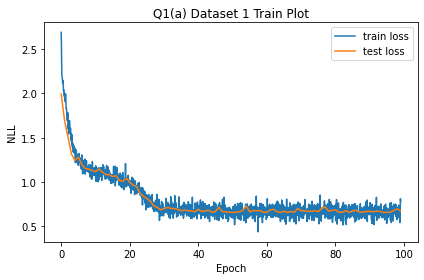

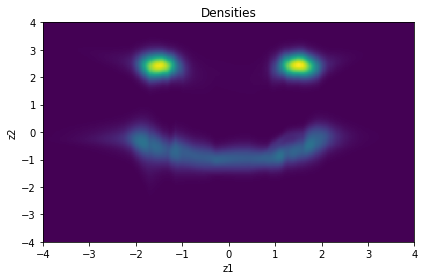

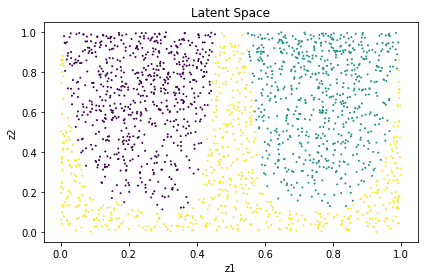

In [ ]:
q1_save_results(1, 'a', q1_a)

Epoch 0, Test loss 1.0452802753448487
Epoch 10, Test loss 0.6361928839683533
Epoch 20, Test loss 0.6380623941421508
Epoch 30, Test loss 0.5957848896980286
Epoch 40, Test loss 0.6074819722175598
Epoch 50, Test loss 0.6271763911247253
Epoch 60, Test loss 0.6177212843894958
Epoch 70, Test loss 0.5897613773345948
Epoch 80, Test loss 0.5977421164512634
Epoch 90, Test loss 0.6009706735610962
Final Test Loss: 0.5963


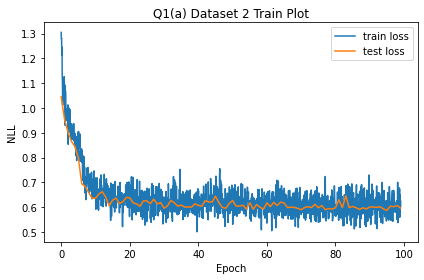

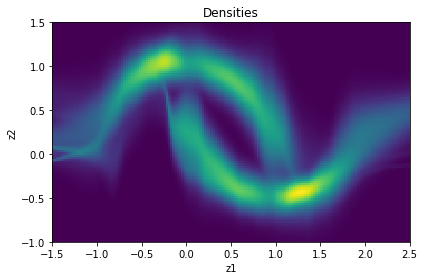

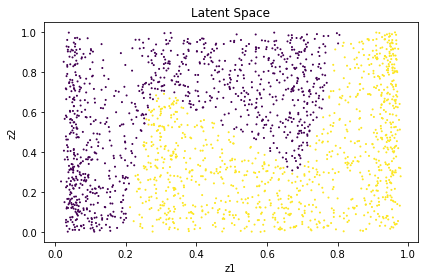

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class AffineTransformation(nn.Module):
  def __init__(self, hidden_size):
    super(AffineTransformation, self).__init__()
    self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.mlp = MLP(input_size=2, hidden_size=hidden_size, output_size=2)
  

  def forward(self, x, mask):
    batch_size = x.shape[0]

    mask = mask.repeat(batch_size, 1)
    masked_x = x * mask

    output = self.mlp(masked_x)
    
    g_scale, g_shift = output[:,0], output[:,1]
    log_scale = self.scale * torch.tanh(g_scale) + self.scale_shift

    g_shift = g_shift.unsqueeze(1) * (1.0 - mask)
    log_scale = log_scale.unsqueeze(1) * (1.0 - mask)   

    z = x *torch.exp(log_scale) + g_shift
    return z, log_scale


In [ ]:
class RealNVP(nn.Module):
  def __init__(self, hidden_dim):
    super(RealNVP, self).__init__()
    self.base_dist = Normal(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))
    self.masks = [torch.tensor([1 - i%2., i%2.]).float().to(device) for i in range(6)]  
    self.AffineTransformations = nn.ModuleList([AffineTransformation(hidden_dim) for i in range(6)])         

  def forward(self, x):
    z, log_det = x.float().to(device), torch.zeros_like(x).to(device)
    for i in range(6):
      z, output_log_det = self.AffineTransformations[i](z, self.masks[i])
      log_det+=output_log_det
    return z, log_det

  def log_prob(self, x):
    z, log_det = self.forward(x)
    l = log_det.sum(1) + (self.base_dist.log_prob(z)).sum(1)
    return l

  def loss(self, x):
    l = self.log_prob(x)
    return -l.mean()


In [ ]:
def q1_b(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in R^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """

  # create data loaders 
 
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  # model
  model = RealNVP(64).to(device)
  model.train()

  # train
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  train_losses, test_losses = train(model, train_loader, test_loader,  optimizer, epoch = 200)

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(device)
  densities = np.exp(model.log_prob(mesh_xs).detach().cpu().numpy())

  # latents
  z, _ = model(torch.tensor(train_data))
  latents = z.detach().cpu().numpy()

  return train_losses, test_losses, densities, latents
  

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch 0, Test loss 3.9130874083445475
Epoch 10, Test loss 2.1758684586953594
Epoch 20, Test loss 1.7202614891875136
Epoch 30, Test loss 1.5949307940266393
Epoch 40, Test loss 1.5900229811071753
Epoch 50, Test loss 1.5819755802164088
Epoch 60, Test loss 1.51873118073136
Epoch 70, Test loss 1.476794295960122
Epoch 80, Test loss 1.5322746118387063
Epoch 90, Test loss 1.5044277104529533
Epoch 100, Test loss 1.5486959712999362
Epoch 110, Test loss 1.5456190631912277
Epoch 120, Test loss 1.5133110581933558
Epoch 130, Test loss 1.5287296534539223
Epoch 140, Test loss 1.5056347821925853
Epoch 150, Test loss 1.5001458744625669
Epoch 160, Test loss 1.4996469837051254
Epoch 170, Test loss 1.457007555632262
Epoch 180, Test loss 1.596032475804662
Epoch 190, Test loss 1.4244263102939059
Final Test Loss: 1.4726


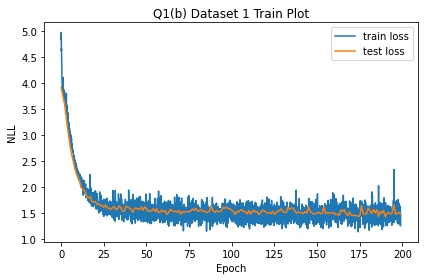

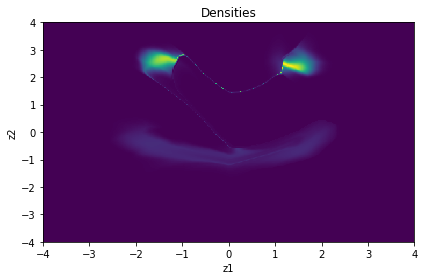

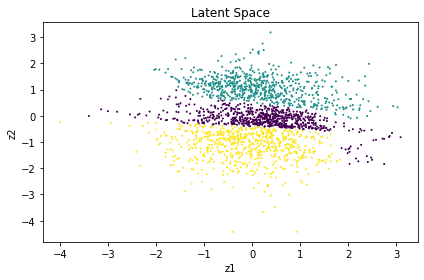

In [ ]:
q1_save_results(1, 'b', q1_b)

Epoch 0, Test loss 2.2362896423339844
Epoch 10, Test loss 1.4759408464431762
Epoch 20, Test loss 1.225978455543518
Epoch 30, Test loss 1.1410542287826537
Epoch 40, Test loss 1.1547527627944947
Epoch 50, Test loss 1.1337886075973511
Epoch 60, Test loss 1.174435489654541
Epoch 70, Test loss 1.1072270860671998
Epoch 80, Test loss 1.110691888809204
Epoch 90, Test loss 1.1108404226303101
Epoch 100, Test loss 1.1357154273986816
Epoch 110, Test loss 1.0965861043930054
Epoch 120, Test loss 1.126080153465271
Epoch 130, Test loss 1.141082384109497
Epoch 140, Test loss 1.0824618701934814
Epoch 150, Test loss 1.1827722311019897
Epoch 160, Test loss 1.1208313608169556
Epoch 170, Test loss 1.1374828786849975
Epoch 180, Test loss 1.1345019025802612
Epoch 190, Test loss 1.080779363632202
Final Test Loss: 1.1227


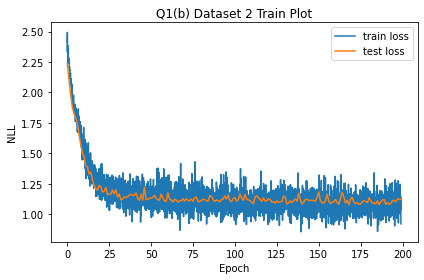

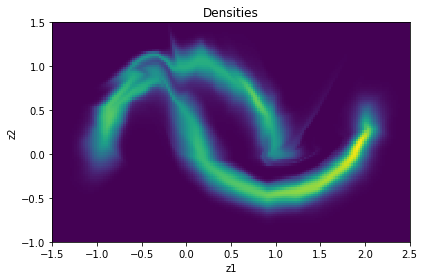

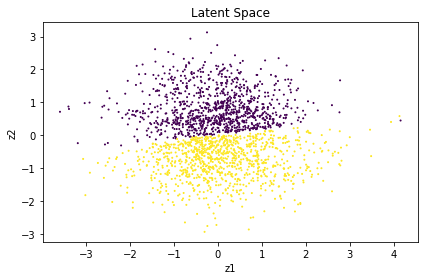

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

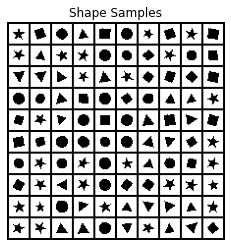

In [ ]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(MaskConv2d, self).__init__(*args, **kwargs)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def forward(self, input):
    batch_size = input.shape[0]
    output = F.conv2d(input, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)
    return output

  def create_mask(self, mask_type):
    h, w = self.kernel_size
    if mask_type == 'A':     
      self.mask[:, :, h // 2, :w // 2] = 1
      self.mask[:, :, :h // 2] = 1
    if mask_type == 'B':
      self.mask[:, :, h // 2, :w // 2 + 1] = 1
      self.mask[:, :, :h // 2] = 1

In [ ]:
class AutoregressiveFlowsforImages(nn.Module):
  def __init__(self, input_shape, kernel_size, k, channels_size):
    super(AutoregressiveFlowsforImages, self).__init__()
    self.n = input_shape[0]
    self.k = k
    self.input_shape = input_shape
    self.ConvB = nn.ModuleList([MaskConv2d('B',channels_size, channels_size, \
                                           kernel_size = kernel_size, \
                                           padding = kernel_size//2) for i in range(5)]) 
    self.ConvB.append(MaskConv2d('B', channels_size, channels_size, kernel_size = 1))
    self.ConvB.append(MaskConv2d('B', channels_size, self.n*k*3, kernel_size = 1))
    self.ConvA = MaskConv2d('A', self.n, channels_size, kernel_size = kernel_size, \
                                           padding = kernel_size // 2)
    
    self.relu = nn.ReLU()
    self.base_dist = Uniform(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))
    self.layer_norm = nn.ModuleList([nn.LayerNorm(channels_size) for i in range(5)]) 
    self.noise = Uniform(torch.tensor(0.0).to(device), torch.tensor(0.5).to(device))

  def forward(self, x):
    output = self.ConvA(x)
    for i in range(7):
      if i< len(self.layer_norm):
        output = self.layer_norm[i](output.permute(0, 2, 3, 1).contiguous())
        output = output.permute(0, 3, 1, 2).contiguous()
      output = self.ConvB[i](self.relu(output))
    return output.view(x.shape[0], 3 * self.k, *self.input_shape) 

  def loss(self, x):
    x = x.to(device).float()/2. + self.noise.sample(x.shape)
    output = self.forward(x)
    logits, means, log_scale = output[:,:self.k], output[:,self.k:self.k*2], output[:,self.k*2:self.k*3]
    weights = F.softmax(logits, dim=1)
    scale = log_scale.exp()
    norm = Normal(means, scale)
    z = (norm.cdf(x.unsqueeze(1).repeat(1, self.k, 1, 1, 1)) * weights).sum(dim=1)
    log_det = (norm.log_prob(x.unsqueeze(1).repeat(1, self.k, 1, 1, 1)).exp() * weights).sum(dim=1).log()
    l = log_det + self.base_dist.log_prob(z)
    return -l.mean()


  def sample(self, n, cond=None):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for h in range(self.input_shape[1]):
        for w in range(self.input_shape[2]):
          for с in range(self.input_shape[0]):
            output = self.forward(samples)
            logits, means, log_scale = output[:,:self.k], output[:,self.k:self.k*2], output[:,self.k*2:self.k*3]
            logits, means, log_scale = logits[:,:,с,h,w], means[:,:,с,h,w], log_scale[:,:,с,h,w]
            probs = F.softmax(logits, dim=1)
            component = torch.multinomial(probs, 1).squeeze(-1)
            scale = log_scale.exp()
            norm = Normal(means[torch.arange(n), component], scale[torch.arange(n), component])
            samples[:, с, h, w] = norm.rsample()
    return samples.permute(0, 2, 3, 1).cpu().numpy()

In [ ]:
def q2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """

  batch_size, H, W, channels = train_data.shape

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  # model
  model = AutoregressiveFlowsforImages((channels, H, W), 7, 10, 64).to(device)
  model.train()

  # train
  optimizer = optim.Adam(model.parameters(), lr=1e-3)
  train_losses, test_losses = train(model, train_loader, test_loader,  optimizer, epoch = 20)

  samples = model.sample(100)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Epoch 0, Test loss -0.4060952118074302
Epoch 10, Test loss -0.5909347640223133
Final Test Loss: -0.6188


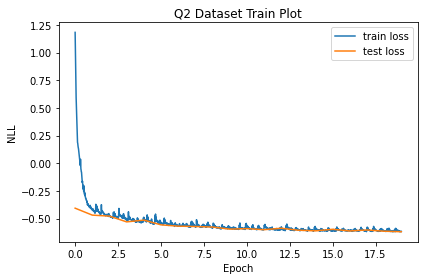

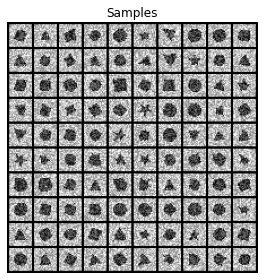

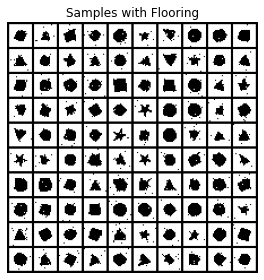

In [ ]:
q2_save_results(q2)

# Question 3: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



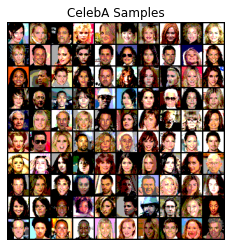

In [ ]:
visualize_q3_data()

## Part (a): RealNVP [40pt]

Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 128, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=n_filters, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=n_filters
  relu()
  conv2d(in_channels=n_filters, out_channels=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.55 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



In [ ]:
q3_save_results(q3_a, 'a')

TypeError: ignored

## Part (b): Exploring bad masking schemes [10pt]

As shown in lecture, the choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

In [ ]:
def q3_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q3_b, 'b')

# Question 4: Bonus Questions (Optional)

## Q4(a): Multiscale RealNVP [10pt]
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_a, 'bonus_a')

## Q4(b): Glow [5pt]
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_b, 'bonus_b')

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)